In [37]:
import sys
sys.path.append('..')
import numpy as np
import pickle
from scipy.io import savemat
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

from utils import *

### Load data

In [42]:
srate = 240
expName = 'sweep'

dir = '../datasets/%s.pickle' % expName
winLENs = np.arange(0.2, 1, step=.2)
with open(dir, "rb") as fp:
    wholeset = pickle.load(fp)

sub = wholeset[2]

chnNames = ['PZ', 'PO5', 'POZ', 'PO4', 'PO6', 'O1', 'OZ','O2']
chnINX = [sub['channel'].index(i) for i in chnNames]
X = sub['wn']['X'][:,chnINX]
y = sub['wn']['y']
S = sub['wn']['STI']
sub['name']

'miaoyining'

_Variable defination_:
- $X$: EEG data, shape as $epoch \times channel \times T$
- $S$: STI sequence, shape as $class \times T$
- $y$: Event labels, shape as $epoch \times 1$

### define model parameters

In [39]:
srate = 240
winLEN = 1 
classNUM = 160
tmin, tmax = 0, .8
# penalty
p = 0.98

## Split dataset

In [50]:
# reshape to class*block*chn*N
X_ = np.stack(X[y == i] for i in np.unique(y))
y_ = np.stack(y[y == i] for i in np.unique(y))

# split conditions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_, y_,test_size=0.9,random_state=253)

X_train,X_test = np.concatenate(X_train, axis=0), np.concatenate(X_test, axis=0)
y_train,y_test = np.concatenate(y_train, axis=0), np.concatenate(y_test, axis=0)
S_train,S_test = np.stack([S[i-1] for i in y_train]),np.stack([S[i-1] for i in y_test])

/Users/shinanlin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


# Fit a forward model

The key to fit a powerful Code2EEG mode is to train by spatially filtered epoch, instead of single epoch ones.

You can start the model by `Code2EEG().fit()`.
1. initialize Code2EEG() class with stimulation sequence:`Code2EEG(S=(STI,np.unique(y))) `
2. `fit(X,y)` takes two parameters
    * $X$: EEG data, shape as $epoch \times channel \times T$ and y
    * $y$: Event labels, shape as $epoch \times 1$
    

In [53]:
from forwardModeling import Code2EEG
code2EEG = Code2EEG(srate=srate,winLEN=winLEN,tmin=tmin,tmax=tmax,S=(S,np.unique(y)),estimator=p,padding=True)
code2EEG.fit(X_train,y_train)

## Predict unseen response

In [54]:
R_ = code2EEG.predict(S_test)
R = code2EEG.enhancer.transform(X_test)

we can inspect a few properties, for example:

1. `code2EEG.trf`: trf in each band, we can reconstruct 
2. `code2EEG.enhanced`: enhanced response for each class
3. `code2EEG.predict(S_test)`: reconstructed response for each test STI seq
4. `code2EEG.enhancer.transform(X_test)`: transform multi-channel response to enhanced response

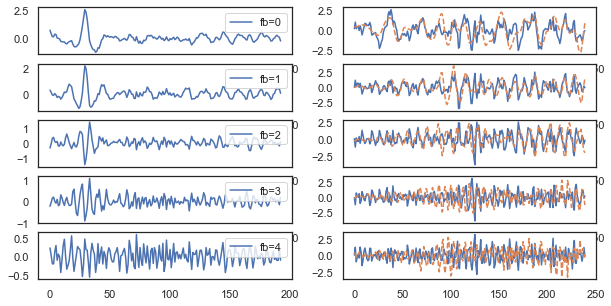

In [55]:
inx = 1
sns.set_theme(style='white')

f, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 5))

for i, ax in enumerate(axs):

    ax[0].plot(code2EEG.trf[i], label='fb=%s' % i)
    ax[1].plot(R[inx][i].T)
    ax[1].plot(R_[inx][i].T, linestyle='dashed')
    ax[0].legend(loc='upper right')
    

# Classification